In [228]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Implementation of optimizers for minmax problem

We define the loss function $L(x,y) = x^TAy$, together with $F(x,y) = [\nabla L_x, -\nabla L_y]$ and want to solve the problem $min_xmax_yL(x,y)$

In [229]:
z0 = np.array([[0.5,.5],[-2.0,-1.0]])
# A = np.array([[0.5,3],[-1,-2]]) # completely unstable
# A = np.array([[0.5,3],[-1,0]])  # only EGM converges
# A = np.array([[1,1],[1,-1]]) # JM doesn't converge!
A = np.array([[1,1],[-1,1]]) # Cool case

In [230]:
# z = (x,y)
def L(A, z):
    return z[0].T @ A @  z[1]

def F(A, z):
    return np.array([A @ z[1], -z[0].T @ A])

In [231]:
def plot_trajectory(points, update_directions, max_iters, title, nb_arrows = 10, line_color = 'b'):
    """Plot the trajectory in the x-y plane of a DTA. 
        INPUT:
            points: list of np.array, each corresponding to one point at one iteration
            grads : list of np.array, each corresponding to the direction to the next iterate"""

    nb_coords = points[0].shape[0]

    for n in range(nb_coords):
        points_n = [p[n] for p in points]     
        xs = [z[0] for z in points_n]
        ys = [z[1] for z in points_n]
        plt.rcParams["figure.figsize"] = (8,8)
        plt.scatter(xs[0], ys[0], color = 'r', lw = 3, label = "Starting point")
        plt.scatter(0, 0, color = 'k', lw = 2, label = "Minimum point", marker='*')
        plt.plot(xs, ys, color = line_color, label = 'Trajectory')

        # Add gradient arrows
        scale = 0.2
        update_n = [p[n] for p in update_directions] 
        x_grads = [z[0] for z in update_n]
        y_grads = [z[1] for z in update_n]
        for i in range(0, max_iters, int(max_iters/nb_arrows)):
            plt.arrow(xs[i], ys[i], scale*x_grads[i], scale*y_grads[i], lw = 1.5, head_width = 0.05, color = line_color)

        ax_lim = 4
        # plt.xlim(-ax_lim,ax_lim)
        # plt.ylim(-ax_lim,ax_lim)
        plt.legend(loc = 'upper right')
        if title is not None:
            plt.suptitle(title + f' coord {n}') 
        plt.show()

## Gradient Descent Ascent
$ z' = z - sF(z)$. Spiral outwards, diverges.

In [232]:
def GDA(A, z0, gamma, max_iters, plot = True):
    """Gradient Descent Ascent algorithm"""
    points = []
    update_directions = []

    z = np.copy(z0)
    #timer = time.time()
    for n_iter in range(max_iters):
        points.append(np.copy(z))
        # Compute update direction
        update_direction = -F(A, z)
        update_directions.append(np.copy(update_direction))

        # Update z with the algorithm
        z += gamma * update_direction
    print(points[len(points)-1])
    
    if plot:
        plot_trajectory(points, update_directions, max_iters, title = 'GDA trajectory for L(x,y) = xAy', line_color='b')

    return points, update_directions


[[ -9.41482658 -13.64370456]
 [ 50.34594027  26.23018963]]


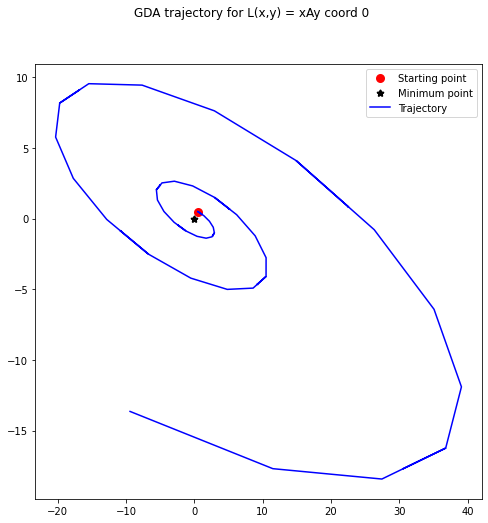

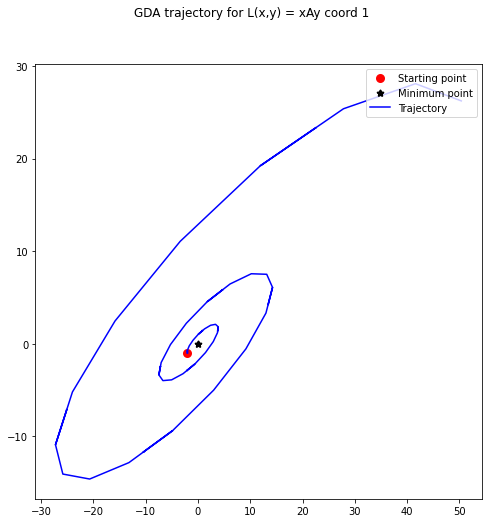

In [233]:
gamma = 0.3
max_iters = 40

points, update_directions = GDA(A, z0, gamma, max_iters)

## Extra Gradient Method 
$z' = z_t - sF(z_t), z_t = z - sF(z)$
Thanks to the computation of the intermediary point z_t, this method spirals inwards, converging to the minimum.

In [234]:
def EGM(A, z0, gamma, max_iters, plot = True):
    """Extra Gradient Method"""
    points = []
    update_directions = []

    z = np.copy(z0)
    z_t = np.copy(z0)
    
    #timer = time.time()
    for n_iter in range(max_iters):
        points.append(np.copy(z))
        # Update intermediary point
        grad_z = F(A, z)
        z_t = z - gamma*grad_z

        # Update next point
        update_direction = -F(A, z_t)
        z += gamma*update_direction

        update_directions.append(np.copy(update_direction))
    print(points[len(points)-1]) 
    #print(timer)

    if plot:
        plot_trajectory(points, update_directions, max_iters, 'EGM trajectory for L(x,y) = xy', nb_arrows = 15, line_color='g')

    return points, update_directions

[[-0.00029578 -0.00014471]
 [ 0.00072993  0.0003272 ]]


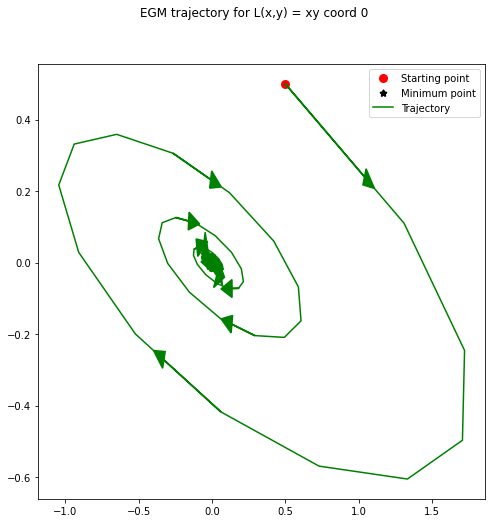

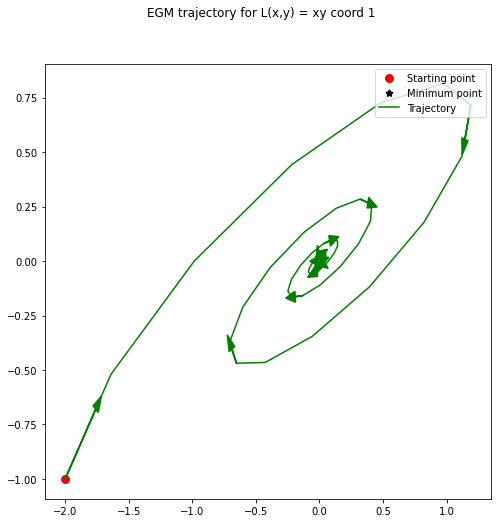

In [235]:
gamma = 0.3
max_iters = 100

points, update_directions = EGM(A, z0, gamma, max_iters)

## Optimistic Gradient Descent Ascent
$z'' = z' - 2sF(z') + sF(z)$

In [236]:
def OGDA(A, z0, gamma, max_iters, plot = True):
    """Optimistic Gradient Descent Ascent Method"""
    points = []
    update_directions = []

    z = np.copy(z0)
    
    # First iteration
    points.append(np.copy(z))
    # Compute update direction
    update_direction = -F(A, z)
    update_directions.append(np.copy(update_direction))

    # Update z with the algorithm
    z += gamma * update_direction

    # Rest of the iterations
    #timer = time.time()
    for n_iter in range(1,max_iters):
        points.append(np.copy(z))
        # Update next iterate point
        grad_z = F(A, z)
        grad_z_minus_1 = F(A, points[n_iter - 1])

        update_direction = -2 * grad_z + grad_z_minus_1
        update_directions.append(update_direction)

        z += gamma*update_direction
    print(points[len(points)-1])
    #print(timer)
    
    if plot:
        plot_trajectory(points, update_directions, max_iters, 'OGDA trajectory for L(x,y) = xy', nb_arrows = 15, line_color='orange')

    return points, update_directions

[[ 6.35318558e-07  1.41118975e-06]
 [-4.86888780e-06 -2.62841170e-06]]


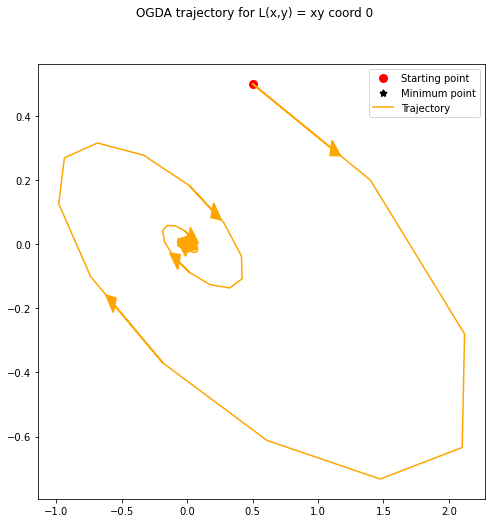

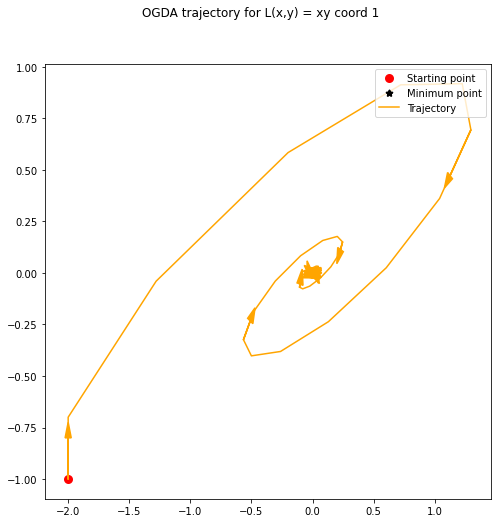

In [237]:
gamma = 0.3
max_iters = 100

points, update_directions = OGDA(A, z0, gamma, max_iters)

## Jacobian Method 
$z' = z + s\nabla F(z) F(z)$

In [238]:
def Grad_F(A,z):
    zeros = np.zeros_like(A)
    return np.array([[zeros, A],[-A.T, zeros]])

In [239]:
def JM(A, z0, gamma, max_iters, plot = True):
    """Jacobian Method"""
    points = []
    update_directions = []

    z = np.copy(z0)
    
    #timer = time.time()
    for n_iter in range(max_iters):
        points.append(np.copy(z))
        # Update next iterate point
        grad_z = F(A, z)
        grad_F = Grad_F(A, z)

        update_direction = (grad_F @ grad_z)

        update_direction = update_direction.sum(axis=(0,1))

        update_directions.append(update_direction)

        z += gamma*update_direction
    print(points[len(points)-1])
    #print(timer)
    
    if plot:
        plot_trajectory(points, update_directions, max_iters, 'JM trajectory for L(x,y) = xy', nb_arrows = 5, line_color='yellow')

    return points, update_directions

[[-3.95222044e-15 -4.76329424e-15]
 [ 1.82421032e-14  7.09336707e-15]]


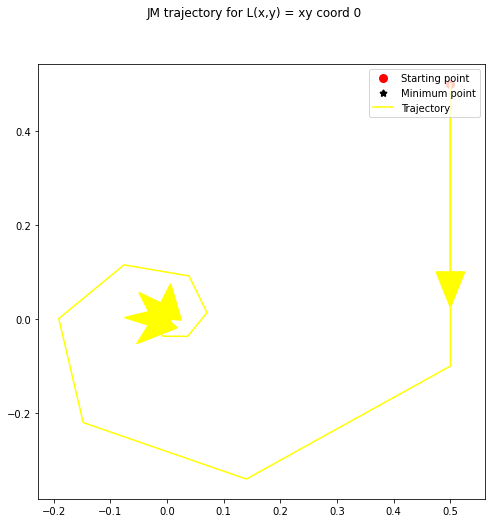

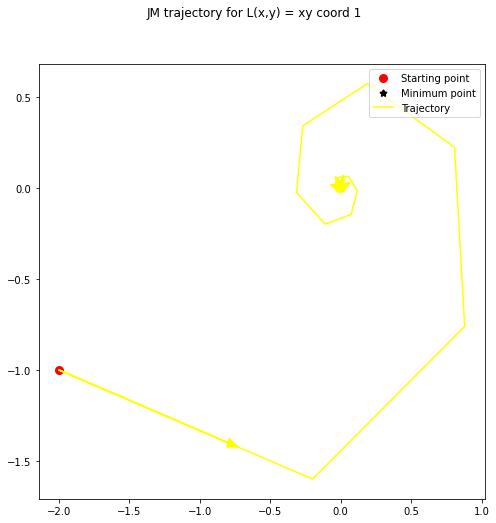

In [240]:
gamma = 0.3
max_iters = 100

points, update_directions = JM(A, z0, gamma, max_iters)

Compare all of them on the same plot

In [241]:
def compare_all_methods(A, z0, gamma, max_iters):
    z_gda, updts_gda = GDA(A, z0, gamma, max_iters, False)
    z_egm, updts_egm = EGM(A, z0, gamma, max_iters, False)
    z_ogda, updts_ogda = OGDA(A, z0, gamma, max_iters, False)
    z_jm, updts_jm = JM(A, z0, gamma, max_iters, False)

    zs = [z_gda, z_egm, z_ogda, z_jm]
    colors = ['b', 'g', 'orange', 'yellow']
    titles = ['GDA', 'EGM', 'OGDA', 'JM']

    nb_coords = z_gda[0].shape[0]

    for n in range(nb_coords):
        plt.scatter(z0[n][0], z0[n][1], color = 'r', lw = 3, label = "Starting point")
        plt.scatter(0, 0, color = 'k', lw = 2, label = "Minimum point", marker='*')

        for i in range(len(zs)):
            points = [p[n] for p in zs[i]]
            xs = [z[0] for z in points]
            ys = [z[1] for z in points]
            plt.rcParams["figure.figsize"] = (8,8)
            plt.plot(xs, ys, color = colors[i], label = f'{titles[i]}')
        
        plt.legend(loc = 'upper right')
        plt.suptitle(f'Trajectories of the 4 methods coord {n}')
        plt.show()

[[10.50087687 -2.76711355]
 [-2.19953623  2.21722949]]
[[ 0.05790648 -0.15651538]
 [ 0.41163966  0.2594253 ]]
[[-0.10295457 -0.03937794]
 [ 0.22108839  0.09465004]]
[[ 0.00081078  0.00116271]
 [-0.0042989  -0.00126962]]


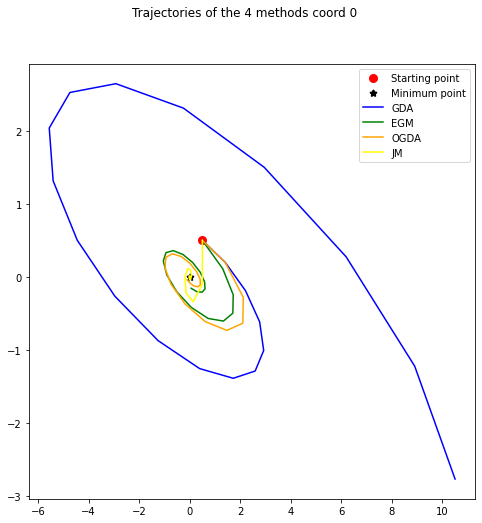

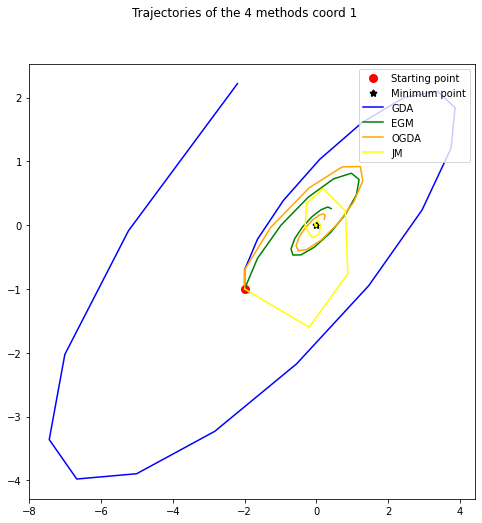

In [242]:
gamma = 0.3
max_iters = 20
compare_all_methods(A, z0, gamma, max_iters)